In [47]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as K
import tensorflow as tf
from src.models.train_model import train_resnet
from src.models.detectors import Detector
from tqdm import tqdm
from copy import deepcopy
from src.data.dataset_loaders import DatasetLoader, AerialCarsDatasetLoader
from typing import Tuple
from src.features.pipelines import RawImageToImage
from src.features.processors import NormImage, Resize
from src.data.image_loaders import AerialCarsSquareImageLoader
from src.models.classifiers import ResnetModelWrapper
from src.models.detectors import NNSliderDetector
from src.data.sliders import SlidingWindow
import matplotlib.pyplot as plt

## Aerial Cars Dataset

In [48]:
DATA_PATH = '../../data/processed/aerial-cars-dataset/data.pickle'

In [49]:
with open(DATA_PATH, 'rb') as f:
    data = pickle.load(f)

### ResNet training

In [50]:
model, history = train_resnet(data, epochs=30)

Epoch 1/30
6/6 [==============================] - 9s 1s/step - loss: 6.8062 - accuracy: 0.5356 - val_loss: 1.5651 - val_accuracy: 0.6667
Epoch 2/30
6/6 [==============================] - 8s 1s/step - loss: 4.5520 - accuracy: 0.5373 - val_loss: 0.8394 - val_accuracy: 0.8182
Epoch 3/30
6/6 [==============================] - 7s 1s/step - loss: 2.2316 - accuracy: 0.6441 - val_loss: 2.1218 - val_accuracy: 0.6515
Epoch 4/30
6/6 [==============================] - 7s 1s/step - loss: 1.8055 - accuracy: 0.7339 - val_loss: 1.0886 - val_accuracy: 0.8333
Epoch 5/30
6/6 [==============================] - 7s 1s/step - loss: 1.1481 - accuracy: 0.8119 - val_loss: 1.0436 - val_accuracy: 0.7273
Epoch 6/30
6/6 [==============================] - 7s 1s/step - loss: 0.8769 - accuracy: 0.8051 - val_loss: 0.5476 - val_accuracy: 0.8939
Epoch 7/30
6/6 [==============================] - 7s 1s/step - loss: 0.5384 - accuracy: 0.8525 - val_loss: 0.4058 - val_accuracy: 0.8333
Epoch 8/30
6/6 [=========================

### Validation

In [51]:
def validate_model(
    dataset_loader: DatasetLoader,
    input_folder_filepath: str,
    images_files_types: Tuple[str],
    annotations_files_types: Tuple[str],
    detector: Detector,
    workers: int = 0
):

    images = dataset_loader.load_dataset(
        input_folder_filepath,
        images_files_types,
        annotations_files_types,
        False
    )

    processed_images = []

    for image in tqdm(images):
        processed_images.append(
            detector(deepcopy(image), workers, False)
        )

    return processed_images

In [60]:
dataset_loader = AerialCarsDatasetLoader(
    image_loader=AerialCarsSquareImageLoader()
)

process_pipeline=RawImageToImage(
    processors=[
        Resize((100, 100)),
        NormImage()
    ]
)

sliding_window = SlidingWindow(
    step_size=50,
    window_size=(128, 128)
)

slider_detector = NNSliderDetector(
    sliding_window=sliding_window,
    process_pipeline=process_pipeline,
    classifier=ResnetModelWrapper(model),
    treshold=0.9,
    nms_overlap=0.4
)

In [61]:
processed_images = validate_model(
    dataset_loader=dataset_loader,
    input_folder_filepath='../../data/raw/aerial-cars-dataset/val',
    images_files_types=('jpg', 'JPG', 'png'),
    annotations_files_types=('txt',),
    detector=slider_detector
)

  0%|          | 0/5 [00:00<?, ?it/s](215, 100, 100, 3)
(215, 100, 100, 3)
(214, 100, 100, 3)
(214, 100, 100, 3)
 20%|██        | 1/5 [00:15<01:02, 15.64s/it]27
24
(215, 100, 100, 3)
(215, 100, 100, 3)
(214, 100, 100, 3)
(214, 100, 100, 3)
 40%|████      | 2/5 [00:30<00:46, 15.51s/it]22
21
(195, 100, 100, 3)
(195, 100, 100, 3)
 60%|██████    | 3/5 [00:37<00:25, 12.78s/it]2
2
(215, 100, 100, 3)
(215, 100, 100, 3)
(214, 100, 100, 3)
(214, 100, 100, 3)
 80%|████████  | 4/5 [00:50<00:12, 12.82s/it]19
19
(200, 100, 100, 3)
(200, 100, 100, 3)
(200, 100, 100, 3)
(200, 100, 100, 3)
(200, 100, 100, 3)
(200, 100, 100, 3)
(200, 100, 100, 3)
(200, 100, 100, 3)
(200, 100, 100, 3)
(200, 100, 100, 3)
(200, 100, 100, 3)
(200, 100, 100, 3)
(200, 100, 100, 3)
(200, 100, 100, 3)
(200, 100, 100, 3)
(200, 100, 100, 3)
(200, 100, 100, 3)
(200, 100, 100, 3)
100%|██████████| 5/5 [01:47<00:00, 21.49s/it]32
17



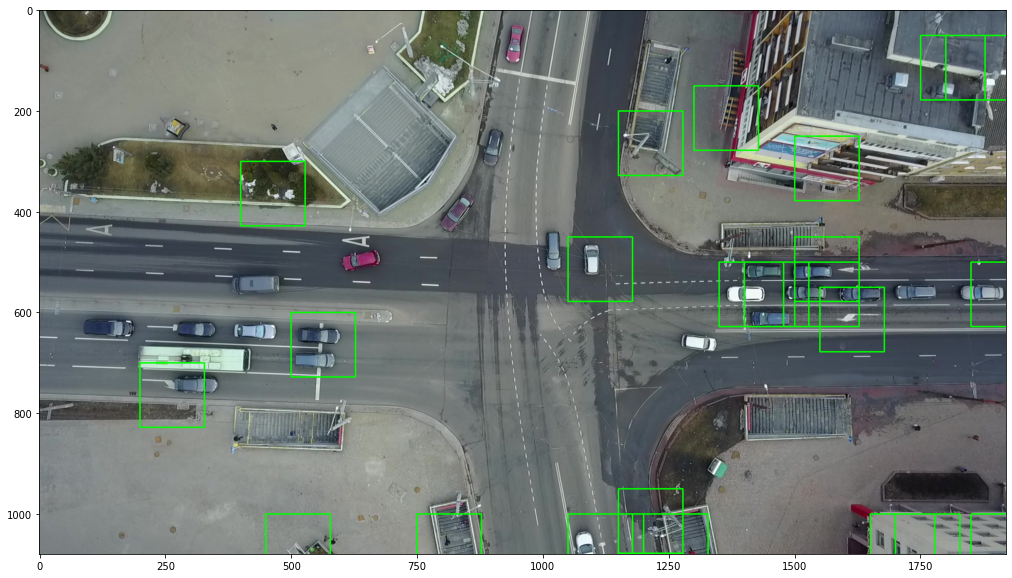

In [63]:
plt.figure(figsize=(20,10))
plt.imshow(processed_images[0][0])